In [1]:
pip install numpy pandas scikit-learn sklearn2pmml seaborn matplotlib keras tensorflow pyarrow fastparquet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn2pmml import sklearn2pmml
from sklearn2pmml import PMMLPipeline
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

2024-07-25 05:53:20.359521: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 05:53:20.371990: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 05:53:20.421784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 05:53:20.503066: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 05:53:20.519464: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 05:53:20.577964: I tensorflow/core/platform/cpu_feature_gu

In [3]:
# Ler os arquivos Parquet
anger = pd.read_parquet('/home/viniciuss/Documents/projetos/emotion-recognition-ml/data/landmarks_data_manually_anotated_ANGER_14mil_samples.parquet')
happiness = pd.read_parquet('/home/viniciuss/Documents/projetos/emotion-recognition-ml/data/landmarks_data_manually_anotated_HAPPINESS_14mil_samples.parquet')
sadness = pd.read_parquet('/home/viniciuss/Documents/projetos/emotion-recognition-ml/data/landmarks_data_manually_anotated_SADNESS_14mil_samples.parquet')
surprise = pd.read_parquet('/home/viniciuss/Documents/projetos/emotion-recognition-ml/data/landmarks_data_manually_anotated_SURPRISE_14mil_samples.parquet')

# Dividir os dados ao meio
half_sadness = len(sadness) // 2
half_anger = len(anger) // 2

sadness_half = sadness.iloc[:half_sadness]
anger_half = anger.iloc[:half_anger]

# Atualizar os valores de 'expression' diretamente
anger_half['expression'] = anger_half['expression'].replace(6, 2)
sadness_half['expression'] = sadness_half['expression'].replace(6, 2)
happiness['expression'] = happiness['expression'].replace(6, 2)
surprise['expression'] = surprise['expression'].replace(6, 2)

# Combinar as metades em um novo DataFrame
sadness_anger_combined = pd.concat([sadness_half, anger_half], ignore_index=True)

# Juntar todos os DataFrames em um único DataFrame
data = pd.concat([sadness_anger_combined, happiness, surprise], ignore_index=True)

# Verificar as primeiras linhas e as contagens de cada emoção
print(data.head())
print(data['expression'].value_counts())

                                           landmarks  expression
0  [0.5326159596443176, 0.7009046077728271, 0.567...           2
1  [0.49526625871658325, 0.6726012229919434, 0.45...           2
2  [0.5196071267127991, 0.7114415168762207, 0.512...           2
3  [0.5070357918739319, 0.7234506011009216, 0.497...           2
4  [0.5144729018211365, 0.7218216061592102, 0.515...           2
expression
2    14000
1    14000
3    14000
Name: count, dtype: int64


/tmp/ipykernel_67064/1149560225.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anger_half['expression'] = anger_half['expression'].replace(6, 2)
/tmp/ipykernel_67064/1149560225.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sadness_half['expression'] = sadness_half['expression'].replace(6, 2)


In [4]:
print('Verificar o Conteúdo de landmarks:')
print(data['landmarks'].head())
print('Confirmar se landmarks Contém Dados:')
print(data['landmarks'].apply(lambda x: isinstance(x, list)).value_counts())
print('Verificar alguns elementos de landmarks para entender o formato')
print(data['landmarks'].apply(type).value_counts())

Verificar o Conteúdo de landmarks:
0    [0.5326159596443176, 0.7009046077728271, 0.567...
1    [0.49526625871658325, 0.6726012229919434, 0.45...
2    [0.5196071267127991, 0.7114415168762207, 0.512...
3    [0.5070357918739319, 0.7234506011009216, 0.497...
4    [0.5144729018211365, 0.7218216061592102, 0.515...
Name: landmarks, dtype: object
Confirmar se landmarks Contém Dados:
landmarks
False    42000
Name: count, dtype: int64
Verificar alguns elementos de landmarks para entender o formato
landmarks
<class 'numpy.ndarray'>    41621
<class 'NoneType'>           379
Name: count, dtype: int64


In [5]:
def convert_landmarks_to_array(df):
    # Substituir NoneType por NaN
    df['landmarks'] = df['landmarks'].apply(lambda x: np.nan if x is None else x)
    
    # Verificar formas antes da conversão
    #check_landmarks_shapes(df)
    
    # Converter landmarks para arrays numpy
    landmarks = df['landmarks'].apply(lambda x: np.array(x) if isinstance(x, (list, np.ndarray)) else np.nan)
    
    # Remover linhas com valores NaN
    df = df.dropna(subset=['landmarks'])
    
    # Verificar e filtrar arrays com comprimento inesperado
    valid_lengths = df['landmarks'].apply(lambda x: len(x) if isinstance(x, np.ndarray) else None).value_counts()
    print('Comprimentos dos arrays de landmarks:')
    print(valid_lengths)
    
    expected_length = valid_lengths.idxmax()  # Usar o comprimento mais frequente
    df = df[df['landmarks'].apply(lambda x: len(x) == expected_length if isinstance(x, np.ndarray) else False)]
    
    # Exibir exemplos de dados para verificar inconsistências
    print('Exemplo de alguns dados em landmarks após limpeza:')
    print(df['landmarks'].head(10))
    
    # Converter listas para arrays numpy
    try:
        X = np.array([np.array(x) for x in df['landmarks']])
    except ValueError as e:
        print("Erro ao converter landmarks para array numpy:", e)
        print("Exemplo de alguns dados em landmarks:")
        print(df['landmarks'].head(10))
        raise

    # Verificar se X é unidimensional e ajustar se necessário
    if X.ndim == 1:
        # Se X for unidimensional, converte para 2D
        X = np.array([x.flatten() for x in X])
    
    # Remove qualquer linha com NaN em X
    if np.any(np.isnan(X)):
        valid_indices = ~np.any(np.isnan(X), axis=1)
        X = X[valid_indices]
        df = df.iloc[valid_indices]
    
    return df, X

# Testar a função
data, X = convert_landmarks_to_array(data)
y = data['expression']

# Exibir resultados
print(X.shape)
print('Conteúdo de alguns exemplos de landmarks:')
print(data['landmarks'].head())
print('Verificar o Número de Linhas Após Remoção de NaNs:')
print("Número de linhas antes da remoção de NaNs:", len(data))
print("Número de linhas após a remoção de NaNs:", len(data))  # Corrigido para usar 'data' em vez de 'df'
print('Verificar a Forma de X e data:')
print("X shape:", X.shape)
print("Número de NaNs em X:", np.isnan(X).sum())

Comprimentos dos arrays de landmarks:
landmarks
956    41621
Name: count, dtype: int64
Exemplo de alguns dados em landmarks após limpeza:
0    [0.5326159596443176, 0.7009046077728271, 0.567...
1    [0.49526625871658325, 0.6726012229919434, 0.45...
2    [0.5196071267127991, 0.7114415168762207, 0.512...
3    [0.5070357918739319, 0.7234506011009216, 0.497...
4    [0.5144729018211365, 0.7218216061592102, 0.515...
5    [0.4272332489490509, 0.7639281749725342, 0.423...
6    [0.4863489270210266, 0.6434009671211243, 0.487...
7    [0.46001899242401123, 0.732892632484436, 0.452...
8    [0.54392009973526, 0.7221582531929016, 0.52595...
9    [0.4205576777458191, 0.8216860294342041, 0.447...
Name: landmarks, dtype: object
(41621, 956)
Conteúdo de alguns exemplos de landmarks:
0    [0.5326159596443176, 0.7009046077728271, 0.567...
1    [0.49526625871658325, 0.6726012229919434, 0.45...
2    [0.5196071267127991, 0.7114415168762207, 0.512...
3    [0.5070357918739319, 0.7234506011009216, 0.497...
4    [

In [6]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exibir as dimensões dos conjuntos de dados
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (33296, 956)
X_test shape: (8325, 956)
y_train shape: (33296,)
y_test shape: (8325,)


In [7]:
# Definir o pipeline com os parâmetros especificados
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

# Treinar o pipeline com os dados de treino
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

              precision    recall  f1-score   support

           1       0.83      0.82      0.83      2775
           2       0.74      0.73      0.74      2783
           3       0.74      0.77      0.76      2767

    accuracy                           0.77      8325
   macro avg       0.77      0.77      0.77      8325
weighted avg       0.77      0.77      0.77      8325

[[2265  299  211]
 [ 219 2043  521]
 [ 229  411 2127]]
Acurácia: 0.77


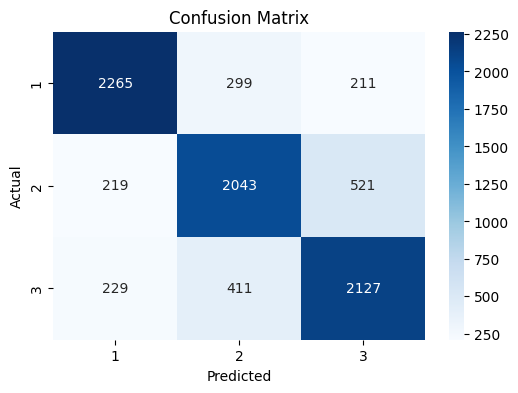

In [8]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Fazer previsões usando o pipeline treinado
y_pred = pipeline.predict(X_test)

# Calcular a acurácia das previsões
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.2f}")

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Salvar PMML
pmml_path = "/home/viniciuss/Documents/projetos/emotion-recognition-api/src/main/resources/model/emotion_recognition_model.pmml"
sklearn2pmml(pipeline, pmml_path, with_repr=True)

Standard output is empty
Standard error:
Exception in thread "main" org.jpmml.sklearn.SkLearnException: This converter version does not know about Scikit-Learn version 1.5.1 artifacts. Please upgrade the converter to the latest version, or downgrade Scikit-Learn to version 1.5.0
	at sklearn.Step.checkSkLearnVersion(Step.java:45)
	at sklearn.Step.checkVersion(Step.java:35)
	at sklearn.Transformer.encode(Transformer.java:71)
	at sklearn.Composite.encodeFeatures(Composite.java:112)
	at sklearn.Composite.initFeatures(Composite.java:255)
	at sklearn.pipeline.SkLearnPipeline.encodePMML(SkLearnPipeline.java:229)
	at com.sklearn2pmml.Main.run(Main.java:80)
	at com.sklearn2pmml.Main.main(Main.java:65)



RuntimeError: The SkLearn2PMML application has failed. The Java executable should have printed more information about the failure into its standard output and/or standard error streams